
> # **Pinterest Celebrity face recognition using Neural Networks**

> **Facial Recognition Dataset collected from Pinterest**  [https://www.kaggle.com/hereisburak/pins-face-recognition](https://www.kaggle.com/hereisburak/pins-face-recognition)

**Dataset Content:**

>These images have been collected from Pinterest and cropped into `3` channel `160x160`. There are `105` celebrities and `17534` faces.

**Description:**
 - The below Python code will split the image dataset into a training set and validation test set based on the given ratio.

**Transfer Learning** [Sourse](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)
 - Deep convolutional neural network models may take days or even weeks to train on very large datasets.
 
 - A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.
 
 - In this project, Transfer Learning has been implemented  with the **MobileNetV2** model and **imagenet** weights.
 
 - The pre-trained model consists of `155` layers and the whole layers of the pretrained model is retrained to get the better accuracy. Image Augmentation has been implemented to avoid the overfitting of the model.

 - The model has been trained for the `50` epochs and the **Validation Accuracy of `96.81%`** has been yielded.

In [1]:
import os

work_dir = # path to the downloaded image dataset

train_dir = os.path.join(work_dir,'train')  #Path of train directory. 
test_dir = os.path.join(work_dir,'test')    #Path of test directory.
os.makedirs(train_dir, exist_ok=True)       #Creating a directory for training examples. 
os.makedirs(test_dir, exist_ok=True)        #Creating a directory for testing examples. 

In [2]:
train_ratio = 0.8
test_ratio = 0.2
dir_list = os.listdir(os.path.join(work_dir ,'105_classes_pins_dataset'))
print('The Number of Classes in the Dataset is:{}'.format(len(dir_list)))

The Number of Classes in the Dataset is:105


Following Code will split up the dataset into training and testing set with respect to the values of train_ratio and test_ratio.

In [3]:
from shutil import copyfile
import numpy as np

source_dir = os.path.join(work_dir ,'105_classes_pins_dataset')   

dir_list = os.listdir(source_dir)

for folder in dir_list:
    data_dir = os.listdir(os.path.join(source_dir,folder))
    np.random.shuffle(data_dir)                            #Shuffling the examples of the classes inside the dataset.
    os.makedirs(os.path.join(train_dir , folder), exist_ok = True)
    os.makedirs(os.path.join(test_dir , folder), exist_ok = True)
    train_data = data_dir[:int(len(data_dir)*train_ratio + 1)] #Splitting the training dataset with respect to the train_ratio.
    test_data = data_dir[-int(len(data_dir)*test_ratio):]
  
    for image in train_data:
        copyfile(os.path.join(source_dir,folder,image) , os.path.join(train_dir,folder,image)) #Copying the Training files from dataset to training directory.
    
    for image in test_data:
        copyfile(os.path.join(source_dir,folder,image) , os.path.join(test_dir,folder,image))  #Copying the Training files from dataset to training directory.
    

In [4]:

print("The Number of Classes in the Training Set:{}".format(len(os.listdir(train_dir))))
print("The Number Of Classes in the Testing Set:{}".format(len(os.listdir(test_dir))))
print('For Verification of the Split.....')
print("The Number of Examples in the Class='pins_Katherine Langford' in the Dataset Directory:{}".format(len(os.listdir(os.path.join(source_dir,'pins_Katherine Langford')))))
print("The Number of Examples in the Class='pins_Katherine Langford' in the Train Directory:{}".format(len(os.listdir(os.path.join(train_dir,'pins_Katherine Langford')))))
print("The Number of Examples in the Class='pins_Katherine Langford' in the Test Directory:{}".format(len(os.listdir(os.path.join(test_dir,'pins_Katherine Langford')))))


The Number of Classes in the Training Set:105
The Number Of Classes in the Testing Set:105
For Verification of the Split.....
The Number of Examples in the Class='pins_Katherine Langford' in the Dataset Directory:226
The Number of Examples in the Class='pins_Katherine Langford' in the Train Directory:214
The Number of Examples in the Class='pins_Katherine Langford' in the Test Directory:78


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rows = 160  #Number of Pixels in the Rows for Input. 
cols = 160  #Number of Pixels in Columns for Output

In [6]:
trained_model = MobileNetV2(input_shape = (rows,cols,3),           
                            include_top = False,
                            weights = 'imagenet')   


trained_model.trainable = True  #Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
    
trained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [7]:
last_layer = trained_model.get_layer('out_relu')   
last_layer_output = last_layer.output  #Saves the output of the last layer of the MobileNetV2.

In [8]:
#Callback Function which stops training when accuracy reaches 98%.
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks = myCallback()

In [9]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(105,activation = 'softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])
#Summary of the model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

In [10]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 40,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
                                 
test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (rows,cols),
                                                    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (rows,cols),
                                                  class_mode = 'categorical')

Found 16845 images belonging to 105 classes.
Found 6236 images belonging to 105 classes.


In [12]:
result = model.fit(train_generator,
                   validation_data = test_generator,
                   epochs = 50,
                   callbacks = [callbacks],
                   verbose = 1)

Epoch 1/50
527/527 [==============================] - 1078s 2s/step - loss: 4.9001 - accuracy: 0.0169 - val_loss: 4.5926 - val_accuracy: 0.0215
Epoch 2/50
527/527 [==============================] - 995s 2s/step - loss: 4.4701 - accuracy: 0.0348 - val_loss: 4.0701 - val_accuracy: 0.0701
Epoch 3/50
527/527 [==============================] - 994s 2s/step - loss: 3.9883 - accuracy: 0.0830 - val_loss: 3.5726 - val_accuracy: 0.1539
Epoch 4/50
527/527 [==============================] - 994s 2s/step - loss: 3.4394 - accuracy: 0.1666 - val_loss: 2.7319 - val_accuracy: 0.3249
Epoch 5/50
527/527 [==============================] - 992s 2s/step - loss: 2.9530 - accuracy: 0.2620 - val_loss: 2.3177 - val_accuracy: 0.4049
Epoch 6/50
527/527 [==============================] - 991s 2s/step - loss: 2.4919 - accuracy: 0.3525 - val_loss: 1.9117 - val_accuracy: 0.5128
Epoch 7/50
527/527 [==============================] - 993s 2s/step - loss: 2.0819 - accuracy: 0.4490 - val_loss: 1.6115 - val_accuracy: 0.574

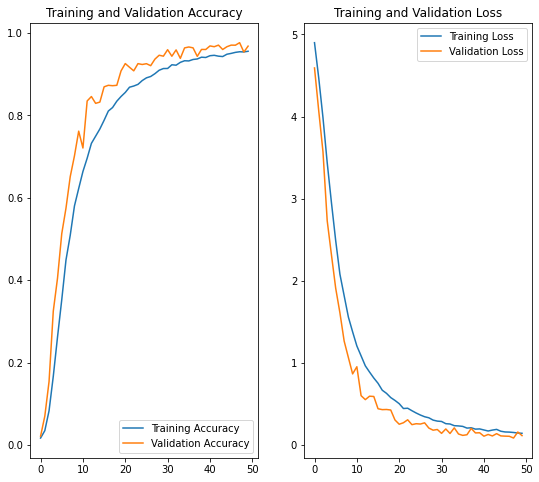

In [13]:
import matplotlib.pyplot as plt

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(50)

plt.figure(figsize = (9, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

Lets test the image jeff bezos205_2090.jpg


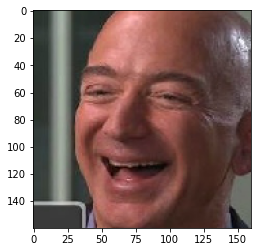

Algorithm predicted that the Person in the Image is Jeff Bezos .


In [14]:
import random
random_name = random.choice(os.listdir(test_dir))
random_image = random.choice(os.listdir(os.path.join(test_dir, random_name)))
print(f"Lets test the image " + random_image)

path = os.path.join(test_dir, random_name, random_image)  #Path to the target image to be predicted. 

classes = train_generator.class_indices
class_names = list(classes.keys())   #List of the class names
img = tf.keras.preprocessing.image.load_img(path, target_size=(rows, cols))

plt.figure()
plt.imshow(img) 
plt.show()


img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array=img_array/255.

score = model.predict(img_array)

print("Algorithm predicted that the Person in the Image is {} .".format(class_names[np.argmax(score)][5:].title()))

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("model saved to disk")
 
import pickle
with open('class_indices.pkl', 'wb') as f:
    pickle.dump(classes, f)
print("class_indices saved to disk")        
 

model saved to disk
class_indices saved to disk


Lets test the image Rihanna88_4075.jpg


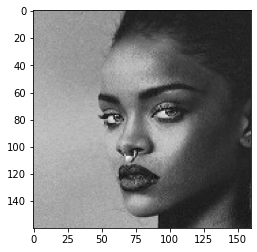

Algorithm predicted that the Person in the Image is Rihanna .


In [33]:
import random
random_name = random.choice(os.listdir(test_dir))
random_image = random.choice(os.listdir(os.path.join(test_dir, random_name)))
print(f"Lets test the image " + random_image)

path = os.path.join(test_dir, random_name, random_image)  #Path to the target image to be predicted. 

classes = train_generator.class_indices
class_names = list(classes.keys())   #List of the class names
img = tf.keras.preprocessing.image.load_img(path, target_size=(rows, cols))

plt.figure()
plt.imshow(img) 
plt.show()


img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array=img_array/255.

score = model.predict(img_array)

print("Algorithm predicted that the Person in the Image is {} .".format(class_names[np.argmax(score)][5:].title()))